# Can You Find the Best Dungeons & Dragons Strategy?

The Riddler - 2020-05-15

> The fifth edition of Dungeons & Dragons introduced a system of “advantage and disadvantage.” When you roll a die “with advantage,” you roll the die twice and keep the higher result. Rolling “with disadvantage” is similar, except you keep the lower result instead. The rules further specify that when a player rolls with both advantage and disadvantage, they cancel out, and the player rolls a single die. Yawn!
>
> There are two other, more mathematically interesting ways that advantage and disadvantage could be combined. First, you could have “advantage of disadvantage,” meaning you roll twice with disadvantage and then keep the higher result. Or, you could have “disadvantage of advantage,” meaning you roll twice with advantage and then keep the lower result. With a fair 20-sided die, which situation produces the highest expected roll: advantage of disadvantage, disadvantage of advantage or rolling a single die?
>
> Extra Credit: Instead of maximizing your expected roll, suppose you need to roll N or better with your 20-sided die. For each value of N, is it better to use advantage of disadvantage, disadvantage of advantage or rolling a single die?

## Intuition

My intuition says that "disadvantage of advantage" is a better strategy.  One way to think about it is that "advantage" will clearly have a better expected value than than "disadvantage", so picking the worse of "advantage" rolls will still be selecting from a population with higher expected values.

Another way to think about this is what rolls get eliminated.  In the "disadvantage of advantage", we first eliminate two low rolls, one from each pair, then eliminate the highest from the two remaining "advantage" rolls.  So we will never select the highest value of the four rolls, nor the lowest of the four rolls (this is true for both "disadvantage of advantage" and "advantage of disadvantage"), but we will only be selecting the lower of the two remaining if the two pairs of rolls do not overlap in values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Expected value of "advantage" and "disadvantage"

There is probably a way to figure out the expected value in closed form, but running simulation is just so much easier.

We will use `np.random.randint` to sample rolls from an N-sided dice.

In [5]:
np.random.randint(low=1, high=20+1, size=1)

array([19])

And if we want to simulate two rolls of the die, repeated 4 times, we pass a shape of (5, 2).

In [9]:
rolls = np.random.randint(low=1, high=20+1, size=(5, 2))
rolls

array([[18, 13],
       [20, 20],
       [18, 16],
       [10,  4],
       [ 1, 20]])

For "advantage", we take the max of the two rolls.  Running this along `axis=1` (running max along the columns) should give us what we want.

In [12]:
rolls.max(axis=1)

array([18, 20, 18, 10, 20])

And finally we can take the mean.  With a large enough sample size, this will approximate the expected value.

Now let's wrap this up in methods.

In [30]:
def expected_value_advantage(n_rolls: int=100, n_sides: int=20) -> float:
    rolls = np.random.randint(low=1, high=n_sides+1, size=(n_rolls, 2))
    return rolls.max(axis=1).mean()

expected_value_advantage(n_rolls=10**6, n_sides=20)

13.822086

We can do something similar for "disadvantage".

In [32]:
def expected_value_disadvantage(n_rolls: int=100, n_sides: int=20) -> float:
    rolls = np.random.randint(low=1, high=n_sides+1, size=(n_rolls, 2))
    return rolls.min(axis=1).mean()

expected_value_disadvantage(n_rolls=10**6, n_sides=20)

7.181395

And as a comparison, we should make sure we understand the expected value of a straight up roll.

In [33]:
def expected_value_roll(n_rolls: int=100, n_sides: int=20) -> float:
    rolls = np.random.randint(low=1, high=n_sides+1, size=n_rolls)
    return rolls.mean()

expected_value_roll(n_rolls=10**6, n_sides=20)

10.494313

## Expected value of "advantage of disadvantage"

We can take advantage of numpy's n-dimensional arrays by adding another dimension.  Whereas previously, `rolls[0]` represented the first roll of "advantage" or "disadvantage" (meaning, it was two rolls, then `min` or `max` applied), now `rolls[0]` will represent the first set of "disadvantage" rolls.

In [25]:
rolls = np.random.randint(low=1, high=20+1, size=(5, 2, 2))
rolls

array([[[15, 11],
        [11, 19]],

       [[14, 10],
        [15, 13]],

       [[12, 16],
        [15, 10]],

       [[ 5,  9],
        [ 5,  8]],

       [[15, 10],
        [17,  2]]])

In [26]:
rolls[0]

array([[15, 11],
       [11, 19]])

In [27]:
rolls[0, 0]

array([15, 11])

So again, we want to apply `min` (for "disadvantage") across the last dimension.

In [28]:
rolls.min(axis=2)

array([[11, 11],
       [10, 13],
       [12, 10],
       [ 5,  5],
       [10,  2]])

And for "advantage" of these pairs of ("disadvantage") rolls, we apply `max` across the last dimension.

In [29]:
rolls.min(axis=2).max(axis=1)

array([11, 13, 12,  5, 10])

Now we can roll it up in a method and run the simulation.

In [35]:
def expected_value_advantage_of_disadvantage(n_rolls: int=100, n_sides: int=20) -> float:
    rolls = np.random.randint(low=1, high=n_sides+1, size=(n_rolls, 2, 2))
    return rolls.min(axis=2).max(axis=1).mean()

expected_value_advantage_of_disadvantage(n_rolls=10**6, n_sides=20)

9.832093

In [36]:
def expected_value_disadvantage_of_advantage(n_rolls: int=100, n_sides: int=20) -> float:
    rolls = np.random.randint(low=1, high=n_sides+1, size=(n_rolls, 2, 2))
    return rolls.max(axis=2).min(axis=1).mean()

expected_value_disadvantage_of_advantage(n_rolls=10**6, n_sides=20)

11.168241

So we see that our intuition was correct and that "disadvantage of advantage" is a better strategy than "advantage of disadvantage".

## Extra credit

Here we are not just interested in maximizing the expected value, but we want the strategy that is best to roll `N` or better on the 20-sided die.

I'm surprised by this question because it suggests that the strategy for maximizing the expected value is not necessarily the best strategy to roll `N` or better for any given `N`.

To get an understanding of this, we can return distributions instead of mean values.

In [52]:
def dist_roll(n_rolls: int=100, n_sides: int=20) -> pd.DataFrame:
    rolls = np.random.randint(low=1, high=n_sides+1, size=n_rolls)
    hist, bins = np.histogram(rolls, bins=n_sides, range=(1, n_sides+1), density=True)
    df = pd.DataFrame(data={'roll': hist}, index=(int(x) for x in bins[:-1]))
    df['roll_or_higher'] = df['roll'][::-1].cumsum()
    return df

dist_roll(n_rolls=10**6, n_sides=20)

,roll,roll_or_higher
1,0.050210,1.000000
2,0.050457,0.949790
3,0.049855,0.899333
4,0.049801,0.849478
5,0.049940,0.799677
6,0.049785,0.749737
7,0.049708,0.699952
8,0.050126,0.650244
9,0.049963,0.600118
10,0.049946,0.550155


In [53]:
def dist_advantage_of_disadvantage(n_rolls: int=100, n_sides: int=20) -> pd.DataFrame:
    rolls = np.random.randint(low=1, high=n_sides+1, size=(n_rolls, 2, 2))
    values = rolls.min(axis=2).max(axis=1)
    hist, bins = np.histogram(values, bins=n_sides, range=(1, n_sides+1), density=True)
    df = pd.DataFrame(data={'aod': hist}, index=(int(x) for x in bins[:-1]))
    df['aod_or_higher'] = df['aod'][::-1].cumsum()
    return df

dist_advantage_of_disadvantage(n_rolls=10**6, n_sides=20)

,aod,aod_or_higher
1,0.009487,1.000000
2,0.026532,0.990513
3,0.040762,0.963981
4,0.052649,0.923219
5,0.061778,0.870570
6,0.068637,0.808792
7,0.073380,0.740155
8,0.076093,0.666775
9,0.076544,0.590682
10,0.076295,0.514138


In [54]:
def dist_disadvantage_of_advantage(n_rolls: int=100, n_sides: int=20) -> pd.DataFrame:
    rolls = np.random.randint(low=1, high=n_sides+1, size=(n_rolls, 2, 2))
    values = rolls.max(axis=2).min(axis=1)
    hist, bins = np.histogram(values, bins=n_sides, range=(1, n_sides+1), density=True)
    df = pd.DataFrame(data={'doa': hist}, index=(int(x) for x in bins[:-1]))
    df['doa_or_higher'] = df['doa'][::-1].cumsum()
    return df

dist_disadvantage_of_advantage(n_rolls=10**6, n_sides=20)

,doa,doa_or_higher
1,0.005205,1.000000
2,0.014967,0.994795
3,0.024756,0.979828
4,0.033845,0.955072
5,0.042976,0.921227
6,0.051111,0.878251
7,0.057859,0.827140
8,0.064273,0.769281
9,0.069789,0.705008
10,0.073524,0.635219


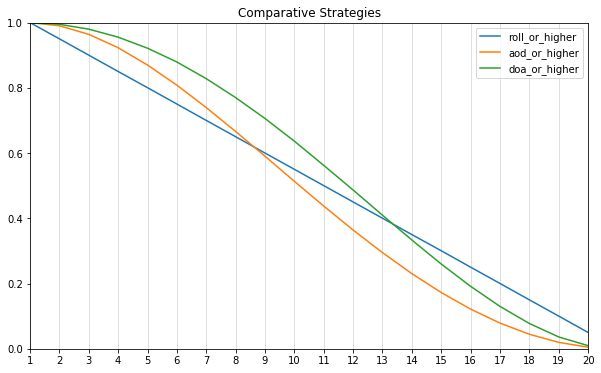

In [64]:
def plot_strategies(n_rolls=100, n_sides=20):
    df_roll = dist_roll(n_rolls=n_rolls, n_sides=n_sides)
    df_aod = dist_advantage_of_disadvantage(n_rolls=n_rolls, n_sides=n_sides)
    df_doa = dist_disadvantage_of_advantage(n_rolls=n_rolls, n_sides=n_sides)
    df = pd.concat([df_roll, df_aod, df_doa], axis=1)
    ax = df.plot.line(y=['roll_or_higher', 'aod_or_higher', 'doa_or_higher'], figsize=(10,6))
    ax.set_title('Comparative Strategies')
    ax.set_ylim(top=1.0, bottom=0.0)
    ax.set_xlim(left=1, right=n_sides)
    ax.set_xticks(range(1, n_sides+1))
    ax.grid(True, axis='x', alpha=0.5)

plot_strategies(n_rolls=10**6, n_sides=20)

This chart gives us a few insights:

- "Disadvantage of advantage" strictly dominates "advantage of disadvantage".
- "Disadvantage of advantage" beats the "single roll" strategy for values of `N` up to and including 13.  But for 14 and higher, it is better to choose the "single roll" strategy.
- "Advantage of disadvantage" beats the "single roll" strategy for values on `N` up to and including 8.  But for 9 and higher, "single roll" is a better strategy.